In [2]:
from scapy.all import rdpcap, Raw
import datetime
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import time
import copy
from scapy.compat import raw
from scapy.error import Scapy_Exception
from scapy.config import conf
from scapy.packet import Packet, bind_layers
from scapy.layers.l2 import Ether
from scapy.layers.inet import UDP
from scapy.fields import (
    XShortEnumField, BitEnumField, XBitField,
    BitField, StrField, PacketListField,
    StrFixedLenField, ShortField,
    FlagsField, ByteField, XIntField, X3BytesField
)

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy
from scapy.all import rdpcap
import datetime
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import time
import copy
import statistics
from sklearn.metrics import mean_squared_error
from scapy.layers.inet import IP
import matplotlib.pyplot as plt

fileName = "/content/drive/MyDrive/opcua-asyncio-tcc/Coletas/None_Function call null deref.pcapng"
userID = 'Marcio Rafael Buzoli'

# Extrair o nome do arquivo sem o caminho e a extensão
fileName2 = fileName.split('/')[-1][:-7]

# Extrair o tipo de ataque do nome do arquivo
securityMode, attackName = fileName2.split('_')

packets = rdpcap(fileName)

chronology_list = []
attack = []
i=0

for i in range(len(packets)):
###########################################
    support_chronology = float(packets[i].time) - float(packets[0].time)
    support_chronology1 ='%.6f'%float(support_chronology)+'000'
    chronology_list.append(support_chronology1)
    source = packets[i].src
    if source == '00:09:5b:bd:64:06' and len(attack) == 0 :
      attackFlag= (support_chronology1, i)
      attack.append(attackFlag)

i = 1
timefilteredPackets = []


for i in range(len(chronology_list)):
  if chronology_list[i] != chronology_list[i-1]:
    timefilteredPackets.append(packets[i])
####################################################################################
####################################################################################
################lista filtrada######################################################
i=0
source_list = []
destination_list = []
packetID_list = []
type_list = []
size_list = []
filteredChronology_list = []


server = '192.168.164.101' #e4:5f:01:2e:1a:b6
client = '192.168.164.102' #e4:5f:01:2e:1b:c1
blackHat = '192.168.164.103' #00:09:5b:bd:64:06

for i in range(len(timefilteredPackets)):
###########################################
    support_chronology = float(timefilteredPackets[i].time) - float(timefilteredPackets[0].time)
    support_chronology1 ='%.6f'%float(support_chronology)+'000'
    filteredChronology_list.append('%.6f'%float(support_chronology1))

    source = timefilteredPackets[i].src
    source_list.append(source)
    destination = timefilteredPackets[i].dst
    destination_list.append(destination)
    payload_length = len(timefilteredPackets[i])
    size_list.append(payload_length)
    typeflag=timefilteredPackets[i].type
    type_list.append(typeflag)

opcua_packets = []

for packet in timefilteredPackets:
    # Verificar se a porta de origem ou destino é 4840 (porta OPC UA)
    if packet.haslayer('IP') and (packet[IP].sport == 4840 or packet[IP].dport == 4840):
        opcua_packets.append(packet)


time = float(filteredChronology_list[-1]) #se necessário
throughput_persecond = []
segment_duration = 1  # Duração do segmento em segundos

for i in range(int(time)):  # Para cada segundo
    flag0 = 0  # Reinicia flag0 para 0 a cada segundo
    for j in range(len(filteredChronology_list)):
        if float(filteredChronology_list[j]) < (i + 1) * segment_duration:  # Verifica se o valor está dentro do segmento
            flag0 += float(size_list[j])  # Soma os valores de size_list dentro do segmento
    # Subtrai os valores de size_list que já foram somados no segundo anterior
    flag0 -= sum(size_list[u] for u in range(len(size_list)) if float(filteredChronology_list[u]) < i * segment_duration)
    throughput_persecond.append(flag0)  # Adiciona o resultado à lista throughput_persecond
    flag0 = 0  # Reinicia flag0 para o próximo segundo


########## Graficos Throughput #######################

# Índice do ataque
attack_index = float(attack[0][0])

# Números de segundos para o eixo x
seconds = list(range(1, len(throughput_persecond) + 1))
throughput_kbps = [value / 1024 for value in throughput_persecond]
# Plotagem do gráfico de linha
plt.figure(figsize=(6, 3))
plt.plot(seconds, throughput_kbps, marker='o', color='g', linewidth=0.5, markersize=6, alpha=0.5, label='Throughput (KBps)')
plt.axvline(x=attack_index + 1, color='r', linestyle='--', linewidth=0.8,label='Início do Ataque')
plt.xlabel('Tempo (segundos)',fontsize= 9)
plt.ylabel('Throughput (KBps)',fontsize= 9)
plt.title('Throughput - Attack Type: {} - Security Mode: {}'.format(attackName, securityMode),fontsize=9)
plt.legend(fontsize= 9)
plt.grid(True, linestyle='dotted')
plt.show()

######## grafico TDE ###########

i=0

server_to_client = []
client_to_server = []
blackHat_to_server = []

for i in range(len(timefilteredPackets)):
  if timefilteredPackets[i].src == 'e4:5f:01:2e:1b:c1' and timefilteredPackets[i].dst == 'e4:5f:01:2e:1a:b6':
    #flag1= (filteredChronology_list[i])
    client_to_server.append(filteredChronology_list[i])
  if timefilteredPackets[i].src == 'e4:5f:01:2e:1a:b6' and timefilteredPackets[i].dst == 'e4:5f:01:2e:1b:c1':
    #flag2= (filteredChronology_list[i])
    server_to_client.append(filteredChronology_list[i])
  if timefilteredPackets[i].src == '00:09:5b:bd:64:06' and timefilteredPackets[i].dst == 'e4:5f:01:2e:1a:b6':
    #flag2= (filteredChronology_list[i])
    blackHat_to_server.append(filteredChronology_list[i])

tdeServerToClient = []
tdeClientToServer = []
i=1
for i in range(len(server_to_client)):
  flag1 = float(server_to_client[i]) - float(server_to_client[i-1])
  if flag1 < 0:
    flag1 = 0
  tdeServerToClient.append(flag1)
for i in range(len(client_to_server)):
  flag2 = float(client_to_server[i]) - float(client_to_server[i-1])
  if flag2 < 0:
    flag2 = 0
  tdeClientToServer.append(flag2)

fator_aumento = 150
# Seus dados
lista1 = tdeServerToClient
lista4 = server_to_client

# Converta o tempo de milissegundos para segundos
lista4_em_segundos = [float(tempo) / 1 for tempo in lista4]

# Crie o gráfico de dispersão
plt.scatter(lista4_em_segundos, lista1, color='blue',alpha=0.3,s=[valor * fator_aumento for valor in lista1],edgecolors='blue', linewidths=1, label='Server to Client')

# Personalize os rótulos do eixo x para mostrar apenas segundos inteiros
intervalo_segundos = 5  # Intervalo entre os rótulos do eixo x em segundos
indices_segundos = list(range(int(min(lista4_em_segundos)), int(max(lista4_em_segundos)) + 1, intervalo_segundos))
rotulos_segundos = [str(segundo) for segundo in indices_segundos]
plt.xticks(indices_segundos, rotulos_segundos)

# Adicione a linha vertical indicando o início do ataque
#plt.axvline(x=attack_index, color='r', linestyle='--', label='Início do Ataque')

# Seus dados
lista2 = tdeClientToServer
lista5 = client_to_server

# Converta o tempo de milissegundos para segundos
lista5_em_segundos = [float(tempo) / 1 for tempo in lista5]

# Crie o gráfico de dispersão
plt.scatter(lista5_em_segundos, lista2, color='r',alpha=0.3,s=[valor * fator_aumento for valor in lista2],edgecolors='r', linewidths=1, label='Client to Server')

plt.xlabel('Tempo (segundos)',fontsize= 9)
plt.ylabel('Valor de TDE (s)',fontsize= 9)
plt.title('TDE - Attack Type: {} - Security Mode: {}'.format(attackName, securityMode),fontsize=9)
plt.grid(True, linestyle='dotted')

# Personalize os rótulos do eixo x para mostrar apenas segundos inteiros
intervalo_segundos = 5  # Intervalo entre os rótulos do eixo x em segundos
indices_segundos = list(range(int(min(lista5_em_segundos)), int(max(lista5_em_segundos)) + 1, intervalo_segundos))
rotulos_segundos = [str(segundo) for segundo in indices_segundos]
plt.xticks(indices_segundos, rotulos_segundos)

# Adicione a linha vertical indicando o início do ataque
plt.axvline(x=attack_index, color='r', linestyle='--',linewidth=0.8,label='Início do Ataque')

# Adicione as legendas
plt.legend(bbox_to_anchor=(0.5,-0.2), fontsize= 9, loc= 'lower center', ncol = 3)

# Mostre o gráfico
plt.show()




ModuleNotFoundError: No module named 'scapy'

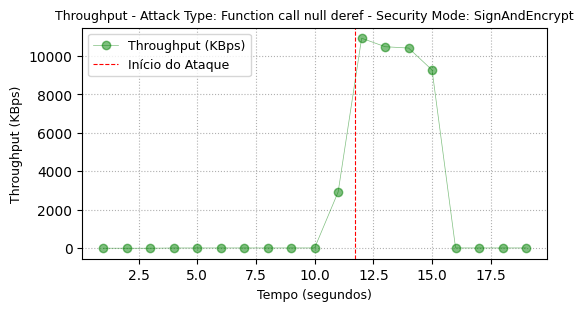

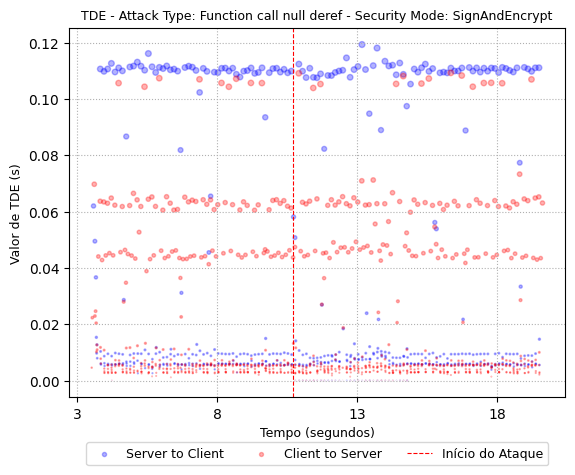

In [5]:
from scapy.all import rdpcap
from scapy.layers.inet import IP
import matplotlib.pyplot as plt

fileName = "/content/drive/MyDrive/opcua-asyncio-tcc/Coletas/SignAndEncrypt_Function call null deref.pcapng"

# Extrair o nome do arquivo sem o caminho e a extensão
fileName2 = fileName.split('/')[-1][:-7]

# Extrair o tipo de ataque do nome do arquivo
securityMode, attackName = fileName2.split('_')
packets = rdpcap(fileName)

chronology_list = []
attack = []

for i in range(len(packets)):
    support_chronology = float(packets[i].time) - float(packets[0].time)
    support_chronology1 = '%.6f' % float(support_chronology) + '000'
    chronology_list.append(support_chronology1)
    source = packets[i].src
    if source == '00:09:5b:bd:64:06' and len(attack) == 0:
        attackFlag = (support_chronology1, i)
        attack.append(attackFlag)

timefilteredPackets = []

for i in range(len(chronology_list)):
    if chronology_list[i] != chronology_list[i - 1]:
        timefilteredPackets.append(packets[i])

source_list = []
destination_list = []
filteredChronology_list = []

for i in range(len(timefilteredPackets)):
    support_chronology = float(timefilteredPackets[i].time) - float(timefilteredPackets[0].time)
    support_chronology1 = '%.6f' % float(support_chronology) + '000'
    filteredChronology_list.append('%.6f' % float(support_chronology1))
    source = timefilteredPackets[i].src
    source_list.append(source)
    destination = timefilteredPackets[i].dst
    destination_list.append(destination)

opcua_packets = []

for packet in timefilteredPackets:
    if packet.haslayer('IP') and (packet[IP].sport == 4840 or packet[IP].dport == 4840):
        opcua_packets.append(packet)

time = float(filteredChronology_list[-1])
throughput_persecond = []
segment_duration = 1

for i in range(int(time)):
    flag0 = 0
    for j in range(len(filteredChronology_list)):
        if float(filteredChronology_list[j]) < (i + 1) * segment_duration:
            flag0 += float(len(timefilteredPackets[j]))
    flag0 -= sum(len(timefilteredPackets[u]) for u in range(len(timefilteredPackets)) if
                 float(filteredChronology_list[u]) < i * segment_duration)
    throughput_persecond.append(flag0)
    flag0 = 0

attack_index = float(attack[0][0])
seconds = list(range(1, len(throughput_persecond) + 1))
throughput_kbps = [value / 1024 for value in throughput_persecond]

plt.figure(figsize=(6, 3))
plt.plot(seconds, throughput_kbps, marker='o', color='g', linewidth=0.5, markersize=6, alpha=0.5, label='Throughput (KBps)')
plt.axvline(x=attack_index + 1, color='r', linestyle='--', linewidth=0.8, label='Início do Ataque')
plt.xlabel('Tempo (segundos)', fontsize=9)
plt.ylabel('Throughput (KBps)', fontsize=9)
plt.title('Throughput - Attack Type: {} - Security Mode: {}'.format(attackName, securityMode), fontsize=9)
plt.legend(fontsize=9)
plt.grid(True, linestyle='dotted')
plt.show()

server_to_client = []
client_to_server = []
blackHat_to_server = []

for i in range(len(timefilteredPackets)):
    if timefilteredPackets[i].src == 'e4:5f:01:2e:1b:c1' and timefilteredPackets[i].dst == 'e4:5f:01:2e:1a:b6':
        client_to_server.append(filteredChronology_list[i])
    if timefilteredPackets[i].src == 'e4:5f:01:2e:1a:b6' and timefilteredPackets[i].dst == 'e4:5f:01:2e:1b:c1':
        server_to_client.append(filteredChronology_list[i])
    if timefilteredPackets[i].src == '00:09:5b:bd:64:06' and timefilteredPackets[i].dst == 'e4:5f:01:2e:1a:b6':
        blackHat_to_server.append(filteredChronology_list[i])

tdeServerToClient = []
tdeClientToServer = []

for i in range(len(server_to_client)):
    flag1 = float(server_to_client[i]) - float(server_to_client[i - 1]) if i > 0 else 0
    if flag1 < 0:
        flag1 = 0
    tdeServerToClient.append(flag1)

for i in range(len(client_to_server)):
    flag2 = float(client_to_server[i]) - float(client_to_server[i - 1]) if i > 0 else 0
    if flag2 < 0:
        flag2 = 0
    tdeClientToServer.append(flag2)

fator_aumento = 150

plt.scatter([float(tempo) / 1 for tempo in server_to_client], tdeServerToClient, color='blue', alpha=0.3,
            s=[valor * fator_aumento for valor in tdeServerToClient], edgecolors='blue', linewidths=1,
            label='Server to Client')

intervalo_segundos = 5
indices_segundos = list(range(int(min([float(tempo) / 1 for tempo in server_to_client])),
                              int(max([float(tempo) / 1 for tempo in server_to_client])) + 1, intervalo_segundos))
rotulos_segundos = [str(segundo) for segundo in indices_segundos]
plt.xticks(indices_segundos, rotulos_segundos)

plt.scatter([float(tempo) / 1 for tempo in client_to_server], tdeClientToServer, color='r', alpha=0.3,
            s=[valor * fator_aumento for valor in tdeClientToServer], edgecolors='r', linewidths=1,
            label='Client to Server')

plt.xlabel('Tempo (segundos)', fontsize=9)
plt.ylabel('Valor de TDE (s)', fontsize=9)
plt.title('TDE - Attack Type: {} - Security Mode: {}'.format(attackName, securityMode), fontsize=9)
plt.grid(True, linestyle='dotted')

intervalo_segundos = 5
indices_segundos = list(range(int(min([float(tempo) / 1 for tempo in client_to_server])),
                              int(max([float(tempo) / 1 for tempo in client_to_server])) + 1, intervalo_segundos))
rotulos_segundos = [str(segundo) for segundo in indices_segundos]
plt.xticks(indices_segundos, rotulos_segundos)

plt.axvline(x=attack_index, color='r', linestyle='--', linewidth=0.8, label='Início do Ataque')

plt.legend(bbox_to_anchor=(0.5, -0.2), fontsize=9, loc='lower center', ncol=3)

plt.show()
